Processing file: /home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw/20210304_0025.root
Processing file: /home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw/20211208_0040.root
Processing file: /home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw/20210220_0013.root
Processing file: /home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw/20210528_0019.root
Processing file: /home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw/20210416_0019.root
Processing file: /home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw/20211107_0029.root
Processing file: /home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw/20211118_001.root
Processing file: /home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw/20211202_0037.root
Processing file: /home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw/20211117_001.root
Processing file: /home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw/20210402_0032.root
Processing file: /home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw/20210208_0013.root
P

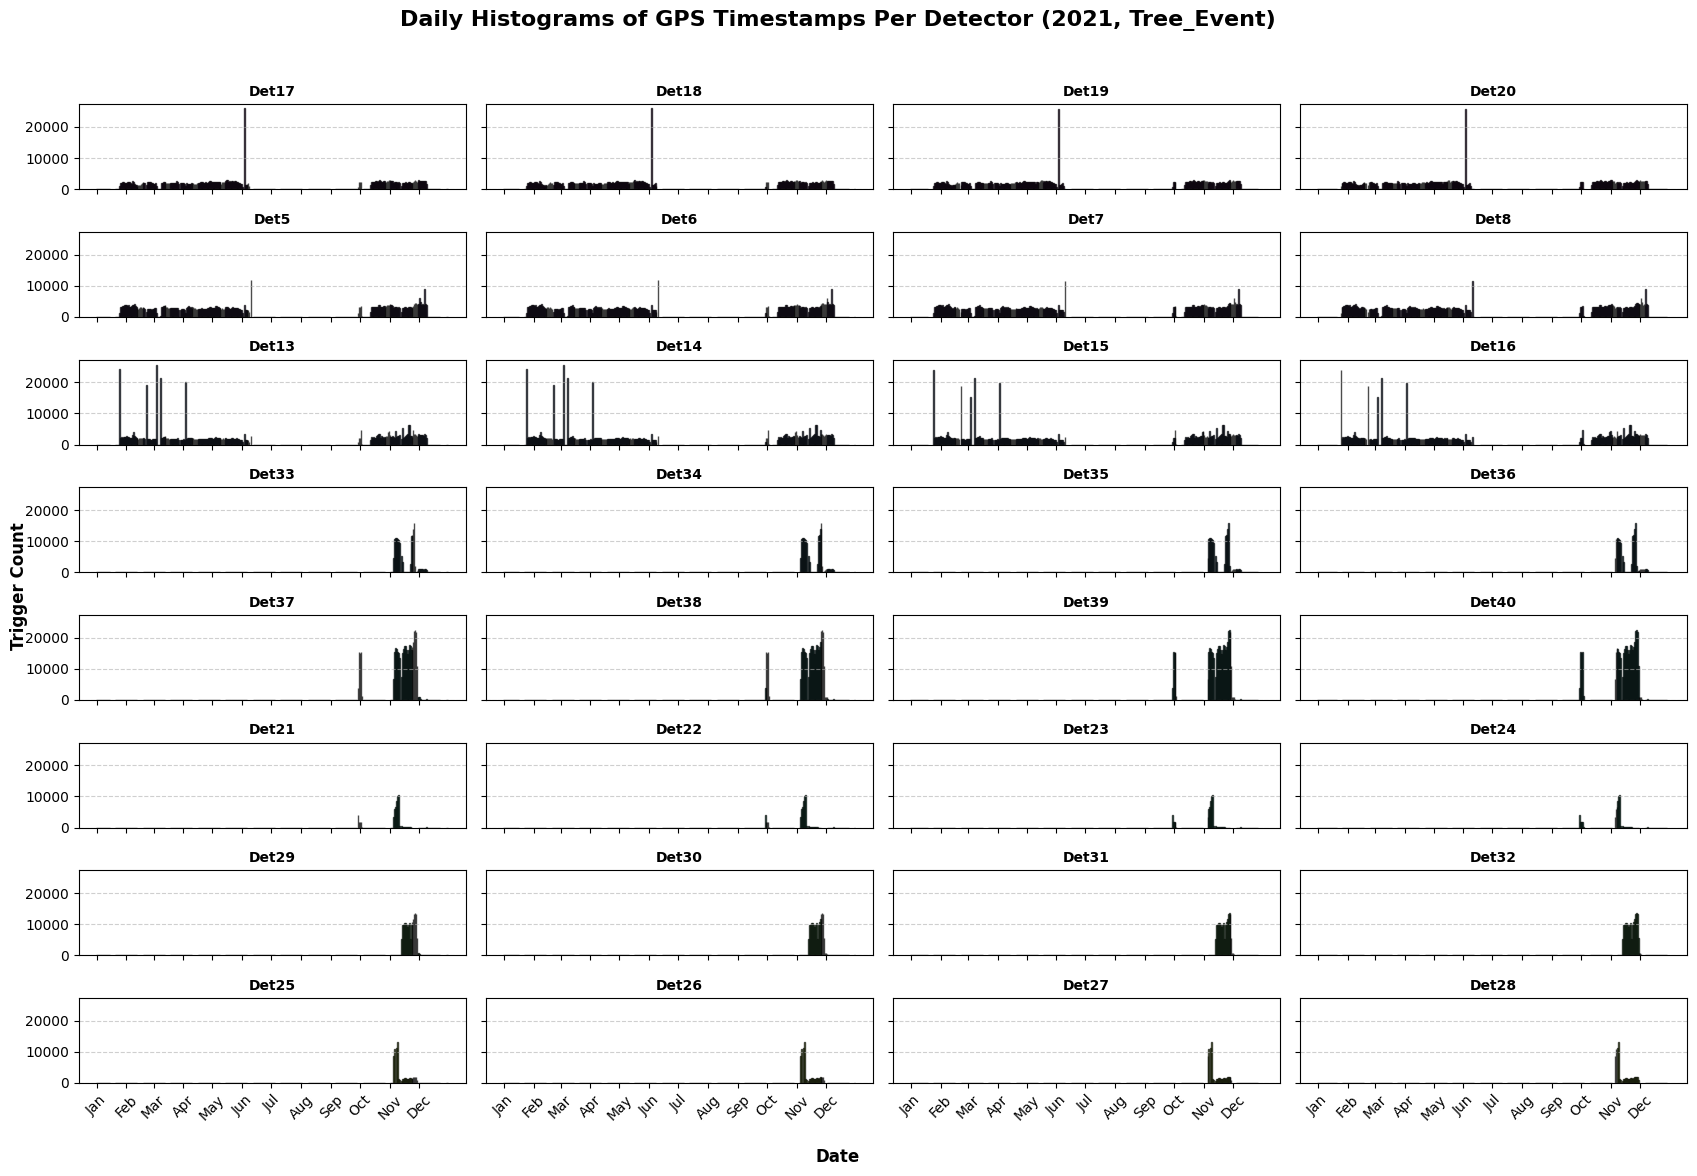

Detector counts saved to detector_countsDay_2021_TreeEvent.txt


In [1]:
"""
This script processes LORA ROOT files for a given year that follow the new ROOT
structure introduced around 2019–2020. In this format, each file contains a
tree named `Tree_Event` with the following relevant branches:

    - GPS_Time_Stamp : int
        GPS timestamp of the triggered event (in seconds since epoch).
    - Detector : int
        Detector ID that registered the event.

The script extracts timestamps per detector, bins them into daily counts,
and generates per-detector histograms for the full year.

Outputs:
    1. A text file named "detector_countsDay_<year>_TreeEvent.txt" containing:
        Detector ID    Day Number    Count
       where Day Number ranges from 0 (Jan 1) to 364/365 (Dec 31).
    2. A matplotlib figure showing daily histograms per detector across the year.

Usage:
    - Update the `directory` and `year` variables as needed.
    - Run the script with Python (requires uproot, numpy, matplotlib).
    - The script automatically handles leap years.

Notes:
    - Only compatible with the new ROOT file structure (Tree_Event).
    - For older data (Tree_event with DetX.GPS_time_stamp), use a different script.
"""
# Daily histogram for the whole year (new ROOT structure: 2020-2021)
import sys
import os
import uproot
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta

# Directory containing the ROOT files
directory = "/home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw"

# Define year for analysis
year = "2021"

def extract_timestamps_and_detectors(file_path):
    """Extract GPS timestamps and detector IDs from ROOT file (Tree_Event)."""
    gps_times, detector_ids = np.array([]), np.array([])
    try:
        with uproot.open(file_path) as f:
            if "Tree_Event" in f:
                tree = f["Tree_Event"]
                gps_times = tree["GPS_Time_Stamp"].array(library="np")
                detector_ids = tree["Detector"].array(library="np")
    except OSError:
        print(f"Skipping file (failed to open): {file_path}")
    return gps_times, detector_ids


# Initialize detector timestamps dictionary
detector_timestamps = defaultdict(list)

# Process each ROOT file for the whole year
for filename in os.listdir(directory):
    if filename.endswith(".root") and filename.startswith(year):
        file_path = os.path.join(directory, filename)
        print(f"Processing file: {file_path}")

        gps_times, det_ids = extract_timestamps_and_detectors(file_path)

        # Collect data into dictionary
        for det, ts in zip(det_ids, gps_times):
            if ts > 1000000000:  # sanity check
                detector_timestamps[f"Det{det}"].append(ts)

# Convert timestamps to daily bins
start_of_year = datetime(int(year), 1, 1)
n_days = 365 if int(year) % 4 != 0 else 366  # account for leap year

daily_bins = [(start_of_year + timedelta(days=i)).timestamp() for i in range(n_days + 1)]

# Set up subplots
num_detectors = len(detector_timestamps)
cols = 4
rows = (num_detectors // cols) + (num_detectors % cols > 0)
if num_detectors == 0:
    print("No detector data was extracted. Please check the input files or data format.")
    sys.exit(1)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

color_palette = plt.cm.viridis(np.linspace(0, 1, (num_detectors // 4) + 1))
colors = [color_palette[i // 4] for i in range(num_detectors)]

# Save histogram data to a text file
output_file = f"detector_countsDay_{year}_TreeEvent.txt"
with open(output_file, "w") as f:
    f.write("Detector ID\tDay Number\tCount\n")
    for i, (det_id, times) in enumerate(detector_timestamps.items()):
        times_days = np.digitize(times, daily_bins) - 1
        hist, _ = np.histogram(times_days, bins=np.arange(n_days + 1))

        for day, count in enumerate(hist):
            f.write(f"{det_id}\t{day}\t{count}\n")

        axes[i].bar(np.arange(n_days), hist, color=colors[i], edgecolor="black", alpha=0.7)
        axes[i].set_title(f"{det_id}", fontsize=10, fontweight="bold")
        axes[i].grid(axis="y", linestyle="--", alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Month labels
month_labels = [datetime(int(year), m, 1).strftime('%b') for m in range(1, 13)]
month_positions = [(datetime(int(year), m, 1) - start_of_year).days for m in range(1, 13)]
for ax in axes:
    ax.set_xticks(month_positions)
    ax.set_xticklabels(month_labels, rotation=45)

fig.text(0.5, 0.02, "Date", ha="center", fontsize=12, fontweight="bold")
fig.text(0.04, 0.5, "Trigger Count", va="center", rotation="vertical", fontsize=12, fontweight="bold")
fig.suptitle(f"Daily Histograms of GPS Timestamps Per Detector ({year}, Tree_Event)", fontsize=16, fontweight="bold")

plt.tight_layout(rect=[0.04, 0.04, 0.98, 0.96])
plt.show()

print(f"Detector counts saved to {output_file}")


In [ ]:
#2011-2019 per day histogram for the whole year: Old Root Structure
import sys

import os
#import uproot
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta

# Directory containing the ROOT files
directory = "/home/wecapstor3/capn/mppi138h/LOFAR/data/LORA/LORAraw"

# Define year for analysis
year = "2013"

def extract_timestamps_and_detectors(file_path):
    """Extract GPS timestamps and detector IDs from ROOT file using uproot."""
    try:
        with uproot.open(file_path) as f:
            if "Tree_Event;1" in f.keys():
                tree = f["Tree_Event"]
                gps_times = tree["GPS_Time_Stamp"].array(library="np")
                detector_ids = tree["Detector"].array(library="np")
                return gps_times, detector_ids
    except OSError:
        print(f"Skipping file (uproot failed to open): {file_path}")
    return np.array([]), np.array([])

def extract_gps_timestamps_per_detector(root_file_path):
    """Extract GPS timestamps from ROOT file for each detector."""
    root_file = ROOT.TFile.Open(root_file_path)
    
    # Skip files that cannot be opened
    if not root_file or root_file.IsZombie():
        print(f"Skipping file (failed to open): {root_file_path}")
        return {}

    tree_event = root_file.Get("Tree_event")
    if not tree_event:
        print(f"Skipping file (missing 'Tree_event'): {root_file_path}")
        root_file.Close()
        return {}

    detector_branches = [branch.GetName() for branch in tree_event.GetListOfBranches() if branch.GetName().startswith("Det")]
    gps_timestamps = {det: [] for det in detector_branches}

    n_entries = tree_event.GetEntries()
    for i in range(n_entries):
        tree_event.GetEntry(i)
        for det in detector_branches:
            gps_leaf = tree_event.GetLeaf(f"{det}.GPS_time_stamp")
            if gps_leaf:
                gps_value = int(gps_leaf.GetValue())
                if gps_value > 1000000000:
                    gps_timestamps[det].append(gps_value)

    root_file.Close()
    return gps_timestamps

# Initialize detector timestamps dictionary
detector_timestamps = defaultdict(list)

# Process each ROOT file for the whole year
for filename in os.listdir(directory):
    if filename.endswith(".root") and filename.startswith(year):
        file_path = os.path.join(directory, filename)
        print(f"Processing file: {file_path}")

        try:
            gps_data = extract_gps_timestamps_per_detector(file_path)
        except OSError as e:
            print(f"Skipping file (error encountered): {file_path} - {e}")
            continue  # Skip the problematic file

        for det, timestamps in gps_data.items():
            detector_timestamps[det].extend(timestamps)

# Convert timestamps to daily bins
start_of_year = datetime(int(year), 1, 1)
n_days = 365

daily_bins = [(start_of_year + timedelta(days=i)).timestamp() for i in range(n_days + 1)]

# Set up subplots
num_detectors = len(detector_timestamps)
cols = 4  # Number of columns in the subplot grid
rows = (num_detectors // cols) + (num_detectors % cols > 0)  # Calculate required rows
if num_detectors == 0:
    print("No detector data was extracted. Please check the input files or data format.")
    sys.exit(1)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()

color_palette = plt.cm.viridis(np.linspace(0, 1, (num_detectors // 4) + 1))
colors = [color_palette[i // 4] for i in range(num_detectors)]

# Save histogram data to a text file
output_file = f"detector_countsDay_{year}.txt"
with open(output_file, "w") as f:
    f.write("Detector ID\tDay Number\tCount\n")
    for i, (det_id, times) in enumerate(detector_timestamps.items()):
        times_days = np.digitize(times, daily_bins) - 1
        hist, _ = np.histogram(times_days, bins=np.arange(n_days + 1))

        for day, count in enumerate(hist):
            f.write(f"{det_id}\t{day}\t{count}\n")

        axes[i].bar(np.arange(n_days), hist, color=colors[i], edgecolor="black", alpha=0.7)
        axes[i].set_title(f"{det_id}", fontsize=10, fontweight="bold")
        axes[i].grid(axis="y", linestyle="--", alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

month_labels = [datetime(int(year), m, 1).strftime('%b') for m in range(1, 13)]
month_positions = [(datetime(int(year), m, 1) - start_of_year).days for m in range(1, 13)]
for ax in axes:
    ax.set_xticks(month_positions)
    ax.set_xticklabels(month_labels, rotation=45)

fig.text(0.5, 0.02, "Date (Weeks)", ha="center", fontsize=12, fontweight="bold")
fig.text(1, 0.5, "Trigger Count", va="center", rotation="vertical", fontsize=12, fontweight="bold")
fig.suptitle(f"Daily Histograms of GPS Timestamps Per Detector ({year})", fontsize=16, fontweight="bold")

plt.tight_layout(rect=[0.02, 0.04, 0.98, 0.96])
plt.show()

print(f"Detector counts saved to {output_file}")


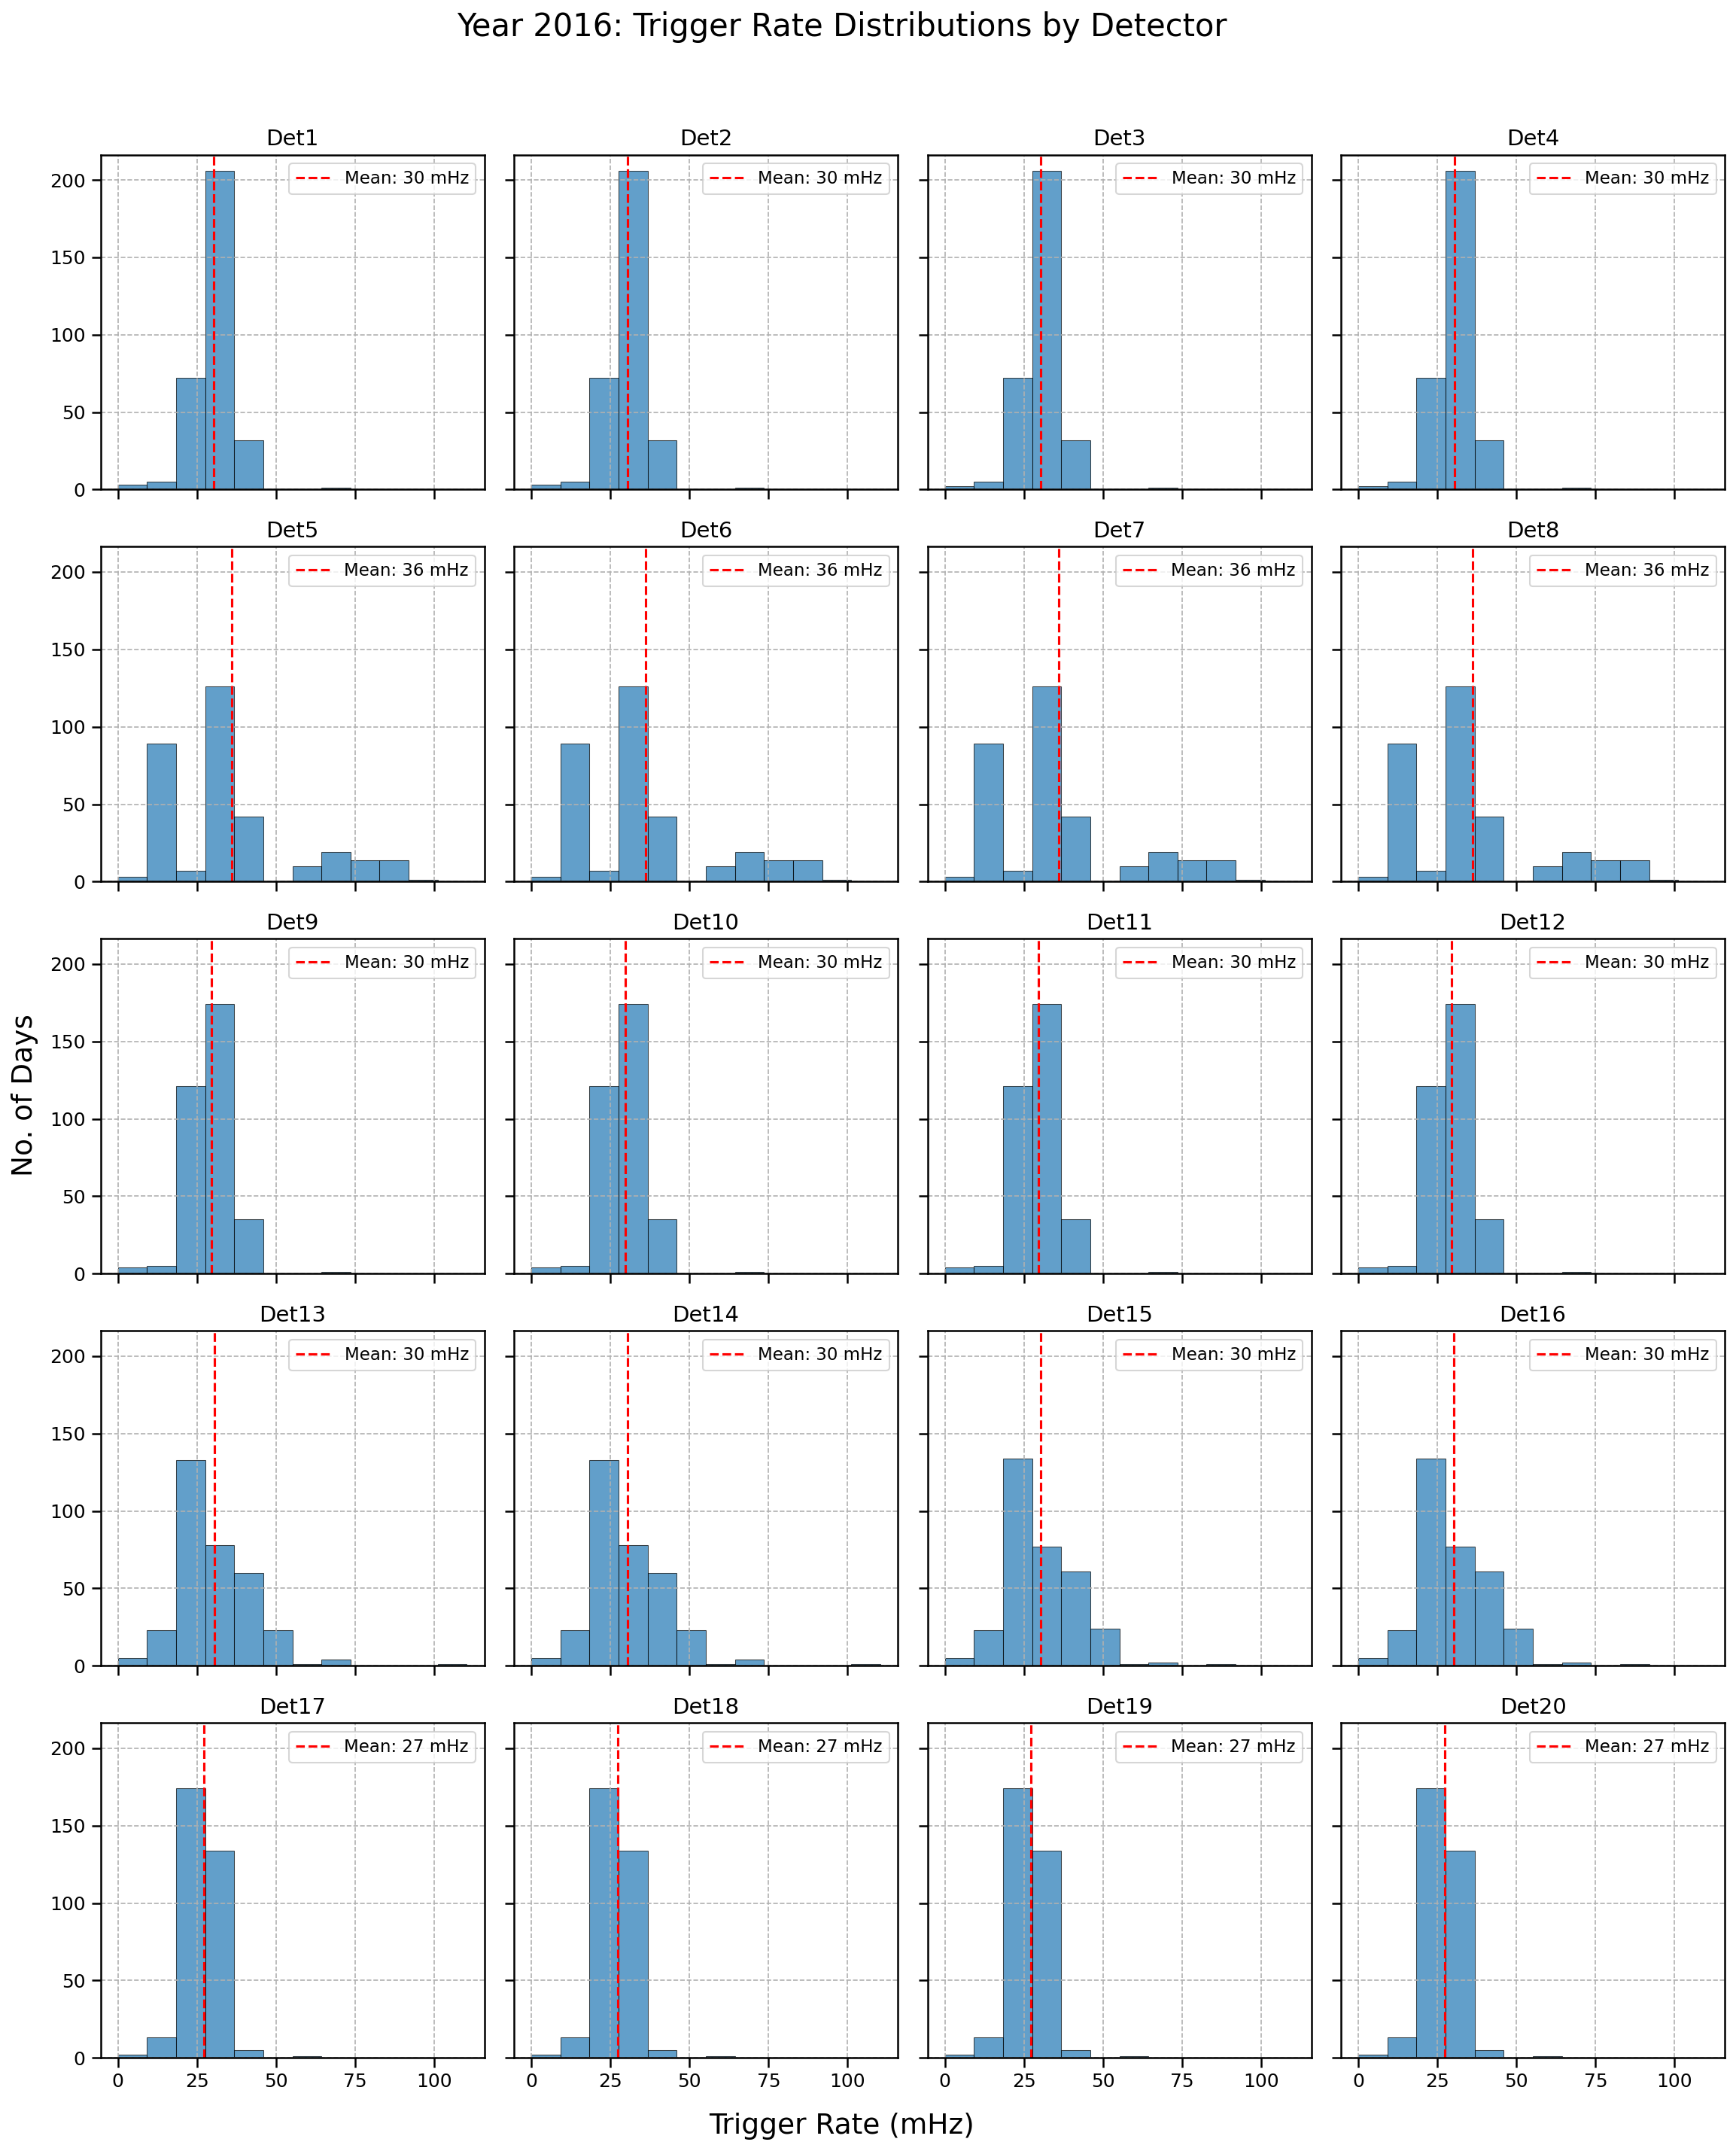

In [ ]:
"""
Counts-to-Rates Analysis and Histogram Plotting for LORA Detectors (2011–2021).

This script reads pre-processed daily detector counts obtained from 
GPS timestamps above and converts them into trigger rates in Hz/mHz.
It then produces histograms of trigger rate distributions
for each detector in a given year.

Data format:
    Each input file must contain tab-separated columns with the following:
        - Detector ID : string (e.g., "Det1", "Det2", ...)
        - Day Number  : integer (0–364/365)
        - Count       : integer (number of triggers on that day)

Processing:
    - Only detectors listed in `detectors` are considered.
    - Days with zero counts are excluded.
    - Trigger rates are computed as:
        Rate_Hz = Count / 86400
      since each day has 86,400 seconds.

Outputs:
    - Interactive histograms: one subplot per detector for the chosen year.
      Each histogram shows the distribution of daily trigger rates,
      with a vertical dashed line indicating the mean rate.
    - The histograms are styled with publication-ready settings
      (consistent font sizes, gridlines, high DPI).

Function:
    plot_trigger_rate_histograms(year, bins=10)
        Creates a grid of subplots (detectors arranged row × col)
        showing trigger rate histograms for all detectors in a given year.

Usage:
    Run the script directly. It will prompt for a year (2011–2021).
    Example:
        $ python counts_to_rates.py
        Enter a year between 2011 and 2021: 2019

Dependencies:
    - pandas
    - numpy
    - matplotlib

Notes:
    - The script assumes all input files are stored in `folder_path`.
    - Make sure to update `folder_path`, `years`, and `detectors` if needed.
    - For detectors Det21–Det40, files must include them (post-upgrade years).
"""
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Plot Layout
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'axes.linewidth': 1.2,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'grid.linestyle': '--',
    'grid.linewidth': 0.8,
    'figure.dpi': 150
})

# --- Configuration ------------------------------------------------------------
folder_path = os.path.expanduser(
    "/home/wecapstor3/capn/mppi138h/LOFAR/scratch/stuti/NuRadioMC/NuRadioReco/LORA/Detector_countsDays"
)
years = list(range(2011, 2022))
detectors = [f"Det{i}" for i in range(1, 41)]  # Det1 to Det20

# --- Load & preprocess all data ------------------------------------------------
all_data = []
for year in years:
    path = os.path.join(folder_path, f"detector_countsDay_{year}.txt")
    df = pd.read_csv(path, sep='\t')
    df['Year'] = year
    df = df[df['Detector ID'].isin(detectors)]
    df = df[df['Count'] > 0]
    df['Rate_Hz'] = df['Count'] / 86400
    all_data.append(df)

data = pd.concat(all_data, ignore_index=True)

# --- Function: Plot histograms for each detector in subplots -------------------
def plot_trigger_rate_histograms(year, bins=12):
    fig, axes = plt.subplots(5, 4, figsize=(16, 20), sharex=True, sharey=True)
    axes = axes.flatten()

    # --- Compute common bin edges for consistency ---
    rates_all = data[data['Year'] == year]['Rate_Hz'].values * 1e3  # convert to mHz
    if len(rates_all) == 0:
        print(f"No data for year {year}")
        return
    bin_edges = np.linspace(rates_all.min(), rates_all.max(), bins + 1)

    for ax, det in zip(axes, detectors):
        grp = data[(data['Year'] == year) & (data['Detector ID'] == det)]
        if grp.empty:
            ax.set_title(f"{det}\n(no data)")
            ax.axis('off')
            continue

        rates = grp['Rate_Hz'].values * 1e3  # convert to mHz

        # histogram with fixed bin edges
        ax.hist(rates, bins=bin_edges, alpha=0.7, edgecolor='black', linewidth=0.5)

        # mean line
        mean_r = rates.mean()
        ax.axvline(mean_r, color='red', linestyle='--', linewidth=1.5,
                   label=f"Mean: {mean_r:.2g} mHz")

        ax.set_title(det)
        ax.grid(True)
        ax.legend(loc='upper right')

    # Global labels
    fig.text(0.5, 0.04, 'Trigger Rate (mHz)', ha='center', fontsize=18)
    fig.text(0.04, 0.5, 'No. of Days', va='center', rotation='vertical', fontsize=18)
    plt.suptitle(f"Year {year}: Trigger Rate Distributions by Detector", fontsize=20)
    plt.tight_layout(rect=[0.05, 0.05, 1, 0.96])
    plt.show()


# --- Usage ----------------------------------------------------------------------
if __name__ == '__main__':
    yr = int(input(f"Enter a year between {years[0]} and {years[-1]}: "))
    if yr in years:
        plot_trigger_rate_histograms(yr, bins=12)
    else:
        print(f"Year must be one of {years}.")

